# Compare all of CPU/GPU/Multi-GPU DataFrame
---

I am an NVIDIA DLI Amabbassador for the "Fundamentals of Accelerated Data Science" and "Accelerating Data Engineering Pipelines" courses, representing South Korea at the Catholic University of Korea.

Currently, I am studying [RAPIDS](https://rapids.ai/) with [Modulabs](https://modulabs.co.kr/). As part of my work, I am creating tutorials to compare the performance of CPU, GPU, and multi-GPU systems.


This [notebook](https://www.kaggle.com/code/cdeotte/compare-cpu-dataframes-to-gpu-dataframes) originally compared only single CPU and GPU performance. I have modified the code to extend the comparisons across most of the RAPIDS ecosystem, providing a broader comparison than the original notebook.

## 1. Import and Check Version of Libraries and CPU/GPU version
---

We are using Pandas Polars, RAPIDS cuDF, Dask, and Dask cuDF

In [1]:
import os
import time
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import platform

import cupy as cp

import dask
import pandas as pd, polars as pl, cudf, dask.dataframe as ddf,dask_cudf as dd
import numpy as np, time
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

head_line  = f"|{'='*39}|"
subhead_line = f"|{'='*19}+{'='*19}|"
split_line = f"+{'-'*19}+{'-'*19}+"
blank_line = f"|{' '*39}|"

print(head_line)
print(f"|{'CPU/GPU Compare Code':^39}|")
print(blank_line)
print(f'|{"Python " +platform.python_version():>39}|')
print(head_line)

print(f"|{'Module':>19}|{'version':>19}|")
print(subhead_line)


print(f"|{'Pandas':>19}|{pd.__version__:>19}|")
print(split_line)

print(f"|{'Polars':>19}|{pl.__version__:>19}|")
print(split_line)

print(f"|{'cuDF':>19}|{cudf.__version__:>19}|")
print(split_line)

print(f"|{'DASK':>19}|{dask.__version__:>19}|")
print(split_line)

print(f"|{'DASK GPU':>19}|{dd.__version__:>19}|")
print(head_line)
  

|=======================================|
|         CPU/GPU Compare Code          |
|                                       |
|                         Python 3.10.15|
|=======================================|
|             Module|            version|
|===================+===================|
|             Pandas|              2.2.2|
+-------------------+-------------------+
|             Polars|              1.8.2|
+-------------------+-------------------+
|               cuDF|           24.10.01|
+-------------------+-------------------+
|               DASK|           2024.9.0|
+-------------------+-------------------+
|           DASK GPU|           24.10.01|
|=======================================|


## 2. Displaying CPU/GPU info
---

In [2]:
!lscpu | head -n 8

Architecture:                         x86_64
CPU op-mode(s):                       32-bit, 64-bit
Byte Order:                           Little Endian
Address sizes:                        43 bits physical, 48 bits virtual
CPU(s):                               16
On-line CPU(s) list:                  0-15
Thread(s) per core:                   2
Core(s) per socket:                   8


In [3]:
!nvidia-smi | head -n 16

Wed Dec  4 14:56:10 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.90.07              Driver Version: 550.90.07      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 2080 ...    Off |   00000000:05:00.0 Off |                  N/A |
|  0%   46C    P8             14W /  250W |      14MiB /   8192MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## 2. Make Test Dataset
---

We create massive datasets to perform comparisons, especially focusing on the differences between the .csv and .parquet file formats.

The .parquet format is generally more efficient for data storage because it supports compression, which significantly reduces file size. Additionally, .parquet stores data in a columnar format, making it particularly well-suited for tasks such as data aggregation.

However, .parquet files are immutable and not human-readable, which can be a limitation depending on your use case.

When selecting a data file format, it is important to consider the nature of your tasks. For example, if you are performing feature engineering, the .parquet format may offer better efficiency due to its columnar storage structure and compression capabilities.

In [4]:
import os

PATH = os.path.join("..", "data", "toy")
os.makedirs(PATH, exist_ok=True)

In [5]:
import random, string

def make_dataframes(seed=0, n_rows=200_000_00, verbose=False):
    
    cp.random.seed(seed)    
    data = {
        'col1': cp.random.rand(n_rows).astype('float32'),
        'col2': cp.random.rand(n_rows).astype('float32'),
        'col3': cp.random.randint(0, 10, n_rows).astype('int'),
        'col4': cp.random.rand(n_rows).astype('float32'), 
    }

    #Make Data Frame    
    df_pandas = cudf.DataFrame(data)
    return df_pandas

In [6]:
make_dataframes(1_000_00).to_csv(os.path.join(PATH, "numbers.csv"))
make_dataframes(10_000_00).to_csv(os.path.join(PATH, "numbers2.csv"))
make_dataframes(100_000_00).to_csv(os.path.join(PATH, "numbers3.csv"))
make_dataframes(200_000_00).to_csv(os.path.join(PATH, "numbers4.csv"))

In [7]:
!ls -lh {PATH}

합계 3.5G
-rw-rw-r-- 1 cvmi_jeyoung cvmi_jeyoung 880M 12월  4 14:56 numbers.csv
-rw-rw-r-- 1 cvmi_jeyoung cvmi_jeyoung 880M 12월  4 14:56 numbers2.csv
-rw-rw-r-- 1 cvmi_jeyoung cvmi_jeyoung 880M 12월  4 14:56 numbers3.csv
-rw-rw-r-- 1 cvmi_jeyoung cvmi_jeyoung 880M 12월  4 14:56 numbers4.csv


## 3. Make Timer and Plot
---


## 4. Read dataframe test
---

In this test, we utilize .read_csv() 

Generally, the .parquet format demonstrates more efficient reading performance on GPUs.

In [8]:
def pandas_read_csv(path):
    return pd.read_csv(path, usecols=['col1', 'col2', 'col3', 'col4'])

def cudf_read_csv(path):
    return cudf.read_csv(path, usecols=['col1', 'col2', 'col3', 'col4'])

def polars_read_csv(path):
    pdf = pl.scan_csv(path).select(['col1', 'col2', 'col3', 'col4'])
    return pdf.collect()

def polars_gpu_read_csv(path):
    pdf = pl.scan_csv(path).select(['col1', 'col2', 'col3', 'col4'])
    return pdf.collect(engine="gpu")

def dask_read_csv(path):
    cdf = ddf.read_csv(path, usecols=['col1', 'col2', 'col3', 'col4'])
    return cdf.persist()

def dask_gpu_read_csv(path):
    gdf = dd.read_csv(path, usecols=['col1', 'col2', 'col3', 'col4'])
    return gdf.persist()


## 5. join dataframe test 

In [9]:
def pandas_join(df):
    return df.merge(df, on='col4')

def cudf_join(df):
    return df.merge(df, on='col4')

def polars_join(df):
    df = df.lazy()
    pdf = (df
           .join(df, on='col4')
      )
    pdf.collect()

def polars_gpu_join(df):
    df = df.lazy()
    pdf = (df
           .join(df, on='col4')
      )
    pdf.collect(engine="gpu")

def dask_join(df):
    cdf = df.merge(df, on='col4').compute()

def dask_gpu_join(df):
    gdf = df.merge(df, on='col4').compute()

## 6.Groupby_mean

In [10]:
def pandas_groupby_mean(df):
    return df.groupby('col3')['col1'].mean()

def cudf_groupby_mean(df):
    df.groupby('col3')['col1'].mean()

def polars_groupby_mean(df):
    df  = df.lazy()
    pdf = (df
           .group_by('col3')
           .agg(pl.col('col1'))
           .mean()
      )
    pdf.collect()

def polars_gpu_groupby_mean(df):
    df = df.lazy()
    pdf = (df
           .group_by('col3')
           .agg(pl.col('col1'))
           .mean()
      )
    pdf.collect(engine="gpu")

def dask_groupby_mean(df):
    df.compute().groupby('col3')['col1'].mean()

def dask_gpu_groupby_mean(df):
    df.compute().groupby('col3')['col1'].mean()

## 7.Filter Test

In [11]:
def pandas_filter(df):
    df[ (df['col1'] > 0.5) & (df['col2'] > 0.5) ]

def cudf_filter(df):
    df[ (df['col1'] > 0.5) & (df['col2'] > 0.5) ]

def polars_filter(df):
    df  = df.lazy()
    pdf = (df
           .filter(pl.col("col1") > 0.5)
           .filter(pl.col("col2") > 0.5)
      )
    pdf.collect()

def polars_gpu_filter(df):
    df = df.lazy()
    pdf = (df
           .filter(pl.col("col1") > 0.5)
           .filter(pl.col("col2") > 0.5)
      )
    pdf.collect(engine="gpu")

def dask_filter(df):
    df[ (df['col1'] > 0.5) & (df['col2'] > 0.5) ].compute()

def dask_gpu_filter(df):
    df[ (df['col1'] > 0.5) & (df['col2'] > 0.5) ].compute()

# 8. Sort Test

In [12]:
def pandas_sort(df):
    df.sort_values(["col1"])

def cudf_sort(df):
    df.sort_values(["col1"])

def polars_sort(df):
    df  = df.lazy()
    pdf = (df
           .sort("col1")
      )
    pdf.collect()

def polars_gpu_sort(df):
    df = df.lazy()
    pdf = (df
           .sort("col1")
      )
    pdf.collect(engine="gpu")

def dask_sort(df):
    df.sort_values(["col1"]).compute()

def dask_gpu_sort(df):
    df.sort_values(["col1"]).compute()

## Main Code
---

In [13]:
def plot_graph(data, n_rows):
    global test_libs, test_func
    num_groups = len(data)
    bar_width = 0.25
    space_between_groups = 1  
    x_pos = np.arange(num_groups) * (bar_width * int(num_groups//2 + 1)+ space_between_groups)  # X positions for groups
    fig, ax = plt.subplots(figsize=(12, 3))
    for i,libs in enumerate(test_libs[:-1]):
        label = f"cuDF vs {libs}"
        bars = ax.bar(x_pos + i * bar_width, [ row[i]/row[-1] for row in data], width=bar_width, label=label)
        
        for j,bar in enumerate(bars):
            height = bar.get_height()
            ax.text(bar.get_x() + (bar.get_width() / 2), height, f'{height:.1f}x', 
                    ha='center', va='bottom', fontsize=10)
    
    ax.set_ylabel('Speed Up Factor')
    ax.set_title(f'RAPIDS cuDF Speed Up versus Pandas and Polars (with {n_rows:.1e} rows dataframe)')
    ax.set_xticks(x_pos + int(num_groups//2) * bar_width)
    ax.set_xticklabels([f"{t}" for t in test_funcs[:int(num_groups)]])
    ax.legend()
    plt.tight_layout()
    plt.show()

In [14]:
ITERS = 10
all_result = []
test_libs = ['pandas', 'polars', 'polars_gpu', 'dask', 'dask_gpu','cudf']
test_funcs = ['read_csv', 'join', 'groupby_mean', 'filter', 'sort' ]

def make_results(data_path):
    results      = []
    for test_name in test_libs:
        
        test_results = []
        ##################
        # Read csv test
        ##################
        func = globals()[f"{test_name}_read_csv"]
        start   = time.time()      # Calc Start      
        for i in range(ITERS):
            rf = func(data_path)
        
        end     = time.time()      # Calc End..
        elapsed = (end-start)/ITERS
        test_results.append(elapsed)
        
        print(f"Now {test_name} testing... Average Data Read time : {elapsed:.4f}")
        ###################
        # Other Function test
        ###################
        for test_func in test_funcs[1:]:
            func = globals()[f"{test_name}_{test_func}"]
            start   = time.time()      # Calc Start      
            for i in range(ITERS):
                func(rf)            
            end     = time.time()      # Calc End..
            elapsed = (end-start)/ITERS
            test_results.append(elapsed)            
            
            print(f"Now {test_func} testing... Average Data Read time : {elapsed:.4f}")
                
        results.append(test_results)
    results = np.array(results).T
    return results

# Test 1_000_00 Sample

Now pandas testing... Average Data Read time : 4.3877
Now join testing... Average Data Read time : 12.2750
Now groupby_mean testing... Average Data Read time : 0.2241
Now filter testing... Average Data Read time : 0.1789
Now sort testing... Average Data Read time : 3.0861
Now polars testing... Average Data Read time : 0.3768
Now join testing... Average Data Read time : 2.2972
Now groupby_mean testing... Average Data Read time : 0.1231
Now filter testing... Average Data Read time : 0.0754
Now sort testing... Average Data Read time : 1.6864
Now polars_gpu testing... Average Data Read time : 1.2449
Now join testing... Average Data Read time : 1.9497
Now groupby_mean testing... Average Data Read time : 0.0362
Now filter testing... Average Data Read time : 0.5689
Now sort testing... Average Data Read time : 1.1056
Now dask testing... Average Data Read time : 2.8148
Now join testing... Average Data Read time : 7.8938
Now groupby_mean testing... Average Data Read time : 0.3935
Now filter test

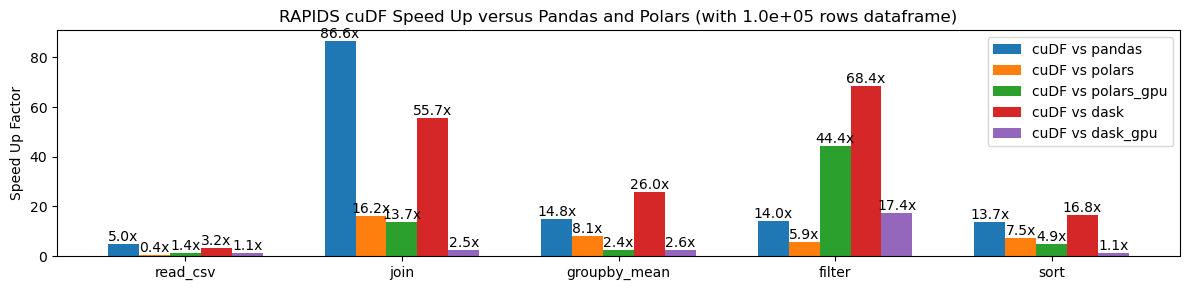

In [15]:
data_path = os.path.join(PATH, "numbers.csv")
results = make_results(data_path)
plot_graph(results, 1_000_00)
all_result.append(results)

# Test 10_000_00 Sample

Now pandas testing... Average Data Read time : 4.7753
Now join testing... Average Data Read time : 14.7717
Now groupby_mean testing... Average Data Read time : 0.2319
Now filter testing... Average Data Read time : 0.1605
Now sort testing... Average Data Read time : 3.1370
Now polars testing... Average Data Read time : 0.3881
Now join testing... Average Data Read time : 2.4670
Now groupby_mean testing... Average Data Read time : 0.1292
Now filter testing... Average Data Read time : 0.0778
Now sort testing... Average Data Read time : 1.7566
Now polars_gpu testing... Average Data Read time : 1.2374
Now join testing... Average Data Read time : 1.9537
Now groupby_mean testing... Average Data Read time : 0.0387
Now filter testing... Average Data Read time : 0.5560
Now sort testing... Average Data Read time : 1.1053
Now dask testing... Average Data Read time : 2.7032
Now join testing... Average Data Read time : 8.2062
Now groupby_mean testing... Average Data Read time : 0.4087
Now filter test

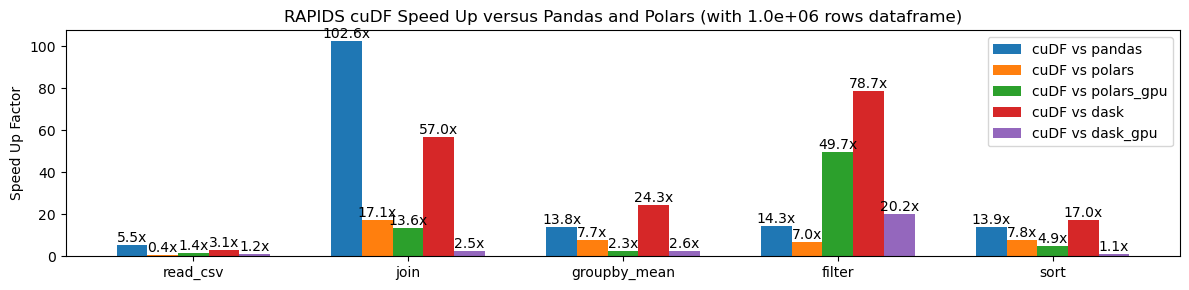

In [16]:
data_path = os.path.join(PATH, "numbers2.csv")
results = make_results(data_path)
plot_graph(results, 10_000_00)
all_result.append(results)

# Test 100_00_000 Sample

Now pandas testing... Average Data Read time : 4.7034
Now join testing... Average Data Read time : 17.7511
Now groupby_mean testing... Average Data Read time : 0.2268
Now filter testing... Average Data Read time : 0.1667
Now sort testing... Average Data Read time : 3.0998
Now polars testing... Average Data Read time : 0.9823
Now join testing... Average Data Read time : 2.3819
Now groupby_mean testing... Average Data Read time : 0.1284
Now filter testing... Average Data Read time : 0.0799
Now sort testing... Average Data Read time : 1.7379
Now polars_gpu testing... Average Data Read time : 1.2389
Now join testing... Average Data Read time : 1.9485
Now groupby_mean testing... Average Data Read time : 0.0375
Now filter testing... Average Data Read time : 0.5576
Now sort testing... Average Data Read time : 1.1120
Now dask testing... Average Data Read time : 2.7831
Now join testing... Average Data Read time : 8.4309
Now groupby_mean testing... Average Data Read time : 0.3995
Now filter test

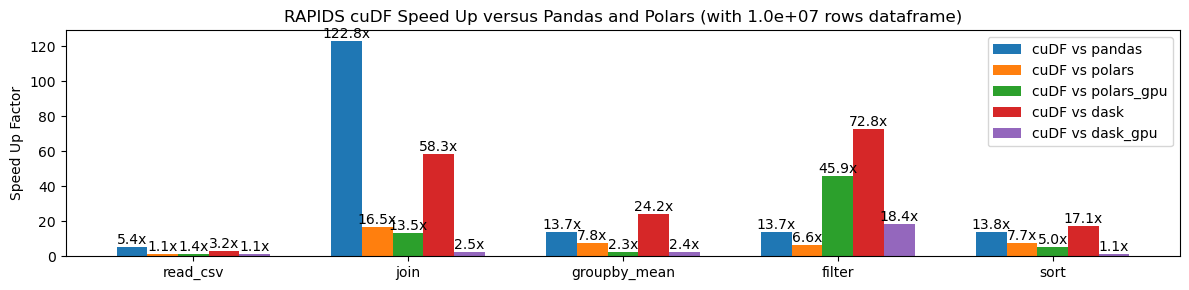

In [17]:

data_path = os.path.join(PATH, "numbers3.csv")
results = make_results(data_path)
plot_graph(results, 100_000_00)
all_result.append(results)

# Test  200_00_000 Sample

Now pandas testing... Average Data Read time : 4.5162
Now join testing... Average Data Read time : 17.9606
Now groupby_mean testing... Average Data Read time : 0.2289
Now filter testing... Average Data Read time : 0.1657
Now sort testing... Average Data Read time : 3.1409
Now polars testing... Average Data Read time : 0.3796
Now join testing... Average Data Read time : 2.3672
Now groupby_mean testing... Average Data Read time : 0.1254
Now filter testing... Average Data Read time : 0.0780
Now sort testing... Average Data Read time : 1.7166
Now polars_gpu testing... Average Data Read time : 1.2391
Now join testing... Average Data Read time : 1.9480
Now groupby_mean testing... Average Data Read time : 0.0375
Now filter testing... Average Data Read time : 0.5576
Now sort testing... Average Data Read time : 1.1054
Now dask testing... Average Data Read time : 2.7211
Now join testing... Average Data Read time : 8.5207
Now groupby_mean testing... Average Data Read time : 0.4019
Now filter test

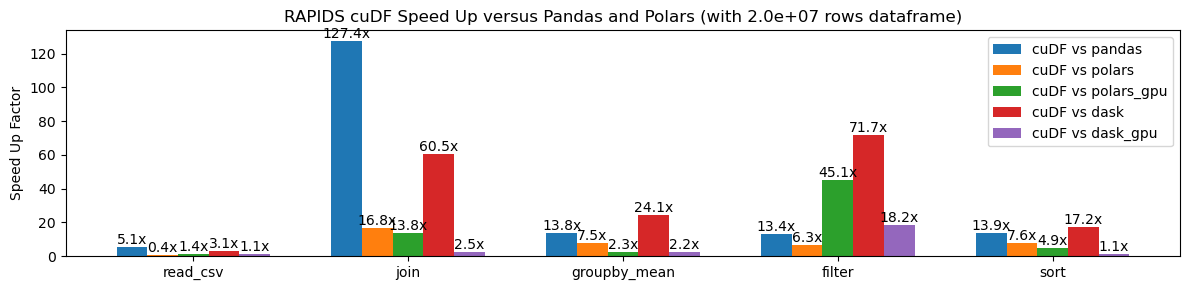

In [18]:

data_path = os.path.join(PATH, "numbers4.csv")
results = make_results(data_path)
plot_graph(results, 200_000_00)
all_result.append(results)

In [19]:
np.mean((np.array(all_result)[..., :5] / np.array(all_result)[..., -1:]).transpose(0, 2, 1)[..., 1:], axis=-1)

array([[32.25358736,  9.42369757, 16.35829789, 41.7073307 ,  5.90323137],
       [36.13270179,  9.87983711, 17.60621401, 44.24227911,  6.58754018],
       [41.02725723,  9.64486677, 16.64761653, 43.11922426,  6.0870113 ],
       [42.12978879,  9.56190299, 16.52846165, 43.38506237,  6.00713656]])

In [20]:
(np.array(all_result)[..., :5] / np.array(all_result)[..., -1:]).transpose(0, 2, 1)

array([[[  5.01836922,  86.56323445,  14.81126687,  13.96370134,
          13.67614678],
        [  0.43092063,  16.19999163,   8.13476435,   5.88679158,
           7.47324274],
        [  1.42379332,  13.74929195,   2.3957763 ,  44.38868269,
           4.8994406 ],
        [  3.21939223,  55.66692884,  26.01097058,  68.39556997,
          16.7558534 ],
        [  1.1349155 ,   2.50411596,   2.62606558,  17.37565045,
           1.10709348]],

       [[  5.46377207, 102.55376026,  13.77389981,  14.33726229,
          13.86588479],
        [  0.44405202,  17.12763554,   7.67577028,   6.95160634,
           7.7643363 ],
        [  1.41574332,  13.56367203,   2.29699819,  49.67865945,
           4.88552639],
        [  3.09288568,  56.97248074,  24.27296953,  78.71510009,
          17.00856609],
        [  1.15046661,   2.4514185 ,   2.57674445,  20.19279495,
           1.12920281]],

       [[  5.38586186, 122.83936495,  13.74374544,  13.71333994,
          13.8125786 ],
        [  1.1248

In [21]:
n_rows = [1_000_00, 10_000_00, 100_000_00, 200_000_00]
x      = []

for r, n in zip(all_result, n_rows):
    x.append(n)

In [22]:
np.median([97.6, 162.7, 16.3, 35.9, 33.2, 175.5])

np.float64(66.75)

In [23]:
np.median([4.99309857,  84.16337073,  13.95006752,  14.72616788,13.49099544, 175.5])

np.float64(14.3381177)